In [1]:
import pandas as pd
import numpy as np
#from funcs import *
import matplotlib.pyplot as plt 
from matplotlib.pyplot import subplot
import seaborn as seabornInstance 
from sklearn import metrics
%matplotlib inline
from functools import reduce
import operator as op
import itertools


In [32]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [33]:
# ----------------------------#
#        LOSS FUNCTIONS 
# ----------------------------#

def mape(y_test, y_pred):
    #return np.mean(np.abs((y_pred-y_test)/y_test))
    return np.mean(np.abs((y_test - y_pred) / y_test))

def mspe(y_test, y_pred):
    return np.mean(np.square((y_pred-y_test)/y_test))

def maape(y_test, y_pred):
    return np.mean(np.arctan(np.abs((y_pred-y_test)/y_test)))

def mae(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))



# ----------------------------------#
#        QUADRATIC OPTIMIZATION 
# ----------------------------------#
import cvxopt

def gauss_filter(x, K, parity='even'):

    # constant
    A = 2*K
    #upper bound of sum
    B = K
    if parity == 'odd':
        A += 1
        B += 1

    const = 1/(2**A)

    x_filtered = []

    # x elements that will see their value change
    r_x = np.arange(K, len(x)-K)

    # range of k
    r_k = np.arange(-K,B+1)

    for i in range(len(x)):
        if i not in r_x:
            x_filtered.append(x[i])
        else:
            # list on which we will save values to be summed to yield new x_tilde_t
            ls = []
            for k in r_k:
                #x_{t-k}
                comb = ncr(A, K+k)
                #print('i: ',i,'k: ',k)
                x_tk = x[i-k]
                #print(comb, x_tk, comb*x_tk)
                #print(ls)
                ls.append(int(comb*x_tk*const))
                #print(ls)
            x_filtered.append(np.sum(ls))
    return x_filtered

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom


def create_M(N):
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i==0:
                if j == 0:
                    M[i,j]=1
                else:
                    M[i,j]=0
            elif (i==j):
                M[i,j]=1
            elif (j == (i-1)):
                M[i,j] = -1
            else:
                M[i,j]=0
    return M

def generate_A(N,k):
    """Create matrix A for equality constraint such that every
    gamma_i == 0, i!=k. This equality holds via the optimization of Ax = b.
    """
    A = np.identity(N)
    #A[k,k] = 0
    return A

def apply_smoothing(X, K, parity):

    new_X = np.zeros(X.shape)

    for j in range(X.shape[1]):
        new_X[:,j] = gauss_filter(X[:,j], K, parity=parity)
        
    
    return new_X

In [34]:
from tqdm import tqdm

def find_best_K(X, y, parity, with_validation=True, training_size=7, model='quadratic'):
    """Returns optimal K such that MAPE error is minimized for the gaussian smoothing"""
    X_new = np.zeros(X.shape)
    N = X.shape[1]
    Ks = np.arange(6,22)
    range_r = [0.00001,0.0001,0.001,0.01, 0.1, 1]
    mapes = []
    dic0 = {}
    dic1 = {}

    for K in Ks:
        dic_loss_per_gamma = {}
        gammas_of_K = []
        #print(K)
        for j in range(X.shape[1]):
            #print(j)
            X_new[:,j]= gauss_filter(X[:,j], K, parity)

        # train on first `tr` days, then  predict 7 next / shiftt of seven until end on dataset
        
        splits = int(np.floor((X.shape[0] - tr)/7))
    
        # list of the mape for a given split, this list is reinitialized for every K
        temp_mapes = []
        y_vals = []
        y_preds = []

        for i in range(splits):
            
            begin = 7*i
            end = tr + 7*i

            X_tr = X_new[begin:end,:]
            y_tr = y[begin:end]

            X_te = X_new[end:end+7,:]
            y_te = y[end:end+7]


                            
            
            mape_per_r = []
            
            #find best r for given split
            for r in range_r:
                
                index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
                P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
                gamma = cvxopt_solve_qp(P, q, G, h, A,b)
                y_pred = X_te@gamma
                y_pred[y_pred < 1 ] = 1
                y_pred = np.floor(y_pred)
                mape_per_r.append(mape(y_te, y_pred))
            
            r = range_r[np.argmin(mape_per_r)]
            #print('Best r for given split is', r)
            P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
            gamma = cvxopt_solve_qp(P, q, G, h, A,b)
            y_pred = X_te@gamma
            y_pred[y_pred < 1 ] = 1
            y_pred = np.floor(y_pred)
            temp_mapes.append(mape(y_te, y_pred))
            #print('y test', y_te, 'and y pred', y_pred, 'have a mape of', mape(y_te, y_pred))

                
        # for K, associate the list of mapes for each split
        dic0[K] = temp_mapes
        
        #append the mean mape for the given K
        mapes.append(np.mean(temp_mapes))
        
        # for K, associate the mean mape between all splits
        dic1[K] = np.mean(temp_mapes)
        
        #########
    
    # return K yielding smallest mean MAPE over all splits, dticionary of mean mape per K, dictionary of all
    # splits mapes per K
    return Ks[np.argmin(mapes)], dic1[Ks[np.argmin(mapes)]] #Ks[np.argmin(mapes)], dic1[Ks[np.argmin(mapes)]]


def generate_params(X_train, y_train,k,N, r=0.01, lambda_=10e-15):
    """
    nb: in this case, the k represents the index of the unique non zero gamma"""
    M = create_M(N)
    M_tilde = M.T @ M
    X_tilde = X_train.T @ X_train
    P = X_tilde + lambda_*(M_tilde)
    q = -X_train.T@y_train
    
    G = np.identity(N)
    G[k,k] = -1
    h = np.zeros((N,1))
    A = generate_A(N, k)
    b = np.zeros((N,1))
    # optimum = 0.001
    b[k] = r
    #b[k] = 0.01
    for i in range(len(h)):
        h[i] = 0.00001
    h[k] = -0.00001
    return P, q, G, h, A, b

def find_best_index(X_train, X_test, y_train, y_test, loss,N,r=0.01):
    """Returns index of unique non zero gamma that minimizes the mae loss"""
    loss = {}
    for k in range(N):
        P, q, G, h, A, b = generate_params(X_train, y_train, k, N, lambda_=10e-15)
        #print('P', P)
        #print('q', q)
        #print('G', G)
        #print('h', h)
        gammas = cvxopt_solve_qp(P, q, G, h, A, b)
        #print(X_test.shape)
        #print(gammas.shape)
        if not (gammas is None):
            y_pred = X_test@gammas
            y_pred[y_pred < 1 ] = 1
            y_pred = np.floor(y_pred)
            loss[k] = mape(y_test,y_pred)
        else:
            loss[k] = 999999999
    return min(loss, key=loss.get)


def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    cvxopt.solvers.options['show_progress'] = False
    P = .5 * (P + P.T)  # make sure P is symmetric
    #print('new P:', P)
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args, initvals=np.ones(N))
    #print('is optimal in solution status', 'optimal' not in sol['status'])
    #print('solution', sol['x'])
    if 'optimal' not in sol['status']:
        return None
    #print(np.array(sol['x']).reshape((P.shape[1],)))
    return np.array(sol['x']).reshape((P.shape[1],))


def exponential_smoothing(x, rho, K):
    const = (1-rho)/(1-rho**(K+1))
    new_x = []
    
    # range of x
    r_x = np.arange(K, len(x)-K)

    # range of k
    r_k = np.arange(0,K)
    
    for i in range(len(x)):
        if i not in r_x:
            new_x.append(x[i])
        else:
            ls = []
            for k in r_k:
                ls.append(int(const*rho**k*x[i-k]))
            new_x.append(np.sum(ls))
                
    return new_x


In [35]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [36]:
X.shape

(107, 30)

In [37]:
from tqdm import tqdm
N = X.shape[1]
training_poss = np.arange(3, 10)
loss_even = []
loss_odd = []
for tr in tqdm(training_poss):
    loss_even.append(find_best_K(X, y, 'even', training_size=tr)[1])
    loss_odd.append(find_best_K(X, y, 'odd', training_size=tr)[1])



  0%|          | 0/7 [00:00<?, ?it/s]


KeyboardInterrupt: 

(2.7, 9.3, 0.2679044124651126, 0.32774942721146016)

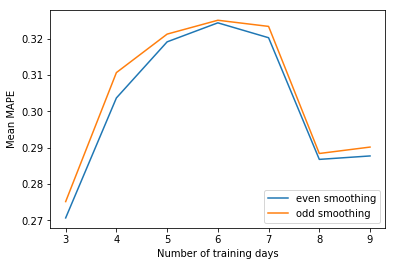

In [484]:
x_data = training_poss
y_data0 = loss_even
y_data1 = loss_odd

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_data, y_data0, label='even smoothing')
ax.plot(x_data, y_data1, label='odd smoothing')
plt.legend()
#plt.title('Mean MAPE loss based on \n the number of training days')

#ax.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
ax.set_xlabel('Number of training days')
ax.set_ylabel('Mean MAPE')

#plt.axvline(x=tr)
#min_ = 'K= ' + str(tr)
#
#ax.annotate(min_, xy=(tr, min(losses[idx])+2))
ax.axis()

In [485]:
minimums = [np.min(loss_even), np.min(loss_odd)]
losses = [loss_even, loss_odd]
idx = np.argmin(minimums) #if 0 even if 1 odd
tr = training_poss[np.argmin(losses[idx])]
parity = ''
if idx == 0:
    K = find_best_K(X, y, parity='even',training_size = tr)[0]
    X = apply_smoothing(X, K, 'even') 
    parity = 'even'
else:
    K = find_best_K(X, y, parity='odd',training_size = tr)[0]
    X = apply_smoothing(X, K, 'odd') 
    parity = 'odd'


In [486]:
print('The minimum loss of ', min(losses[idx]), ' is obtained using ', tr, ' training days with an', parity, 'parity and K=', K)

The minimum loss of  0.2706246404081284  is obtained using  3  training days with an even parity and K= 21


In [41]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

N = X.shape[1]

tr = 3

tr0 = 4

X0 = apply_smoothing(X, 19, 'odd')

In [42]:
def compute_preds(X, tr):

    N = X.shape[1]

    splits = int(np.floor((X.shape[0] - tr)/7))

    # list of the mape for a given split, this list is reinitialized for every K
    temp_mapes = []
    y_vals = []
    indexes = []
    y_preds = []
    gammas = []
    range_r = [0.00001,0.0001,0.001,0.01, 0.1, 1]
    rs = []
    for i in range(splits):

        begin = 7*i
        end = tr + 7*i

        X_tr = X[begin:end,:]
        y_tr = y[begin:end]

        X_te = X[end:end+7,:]
        y_te = y[end:end+7]

        mape_per_r = []
        indexes_temp = []
        for r in range_r:

            index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
            P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
            gamma = cvxopt_solve_qp(P, q, G, h, A,b)
            y_pred = X_te@gamma
            y_pred[y_pred < 1 ] = 1
            y_pred = np.floor(y_pred)
            mape_per_r.append(mae(y_te, y_pred))

        r = range_r[np.argmin(mape_per_r)]
        rs.append(r)
        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
        indexes.append(index)
        #print('Best r for given split is', r)
        P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h, A,b)
        y_pred = X_te@gamma
        y_pred[y_pred < 1 ] = 1
        y_pred = np.floor(y_pred)
        temp_mapes.append(mae(y_te, y_pred))
        y_preds.append(y_pred)
        gammas.append(gamma)
        
    print(np.mean(temp_mapes))
    y_preds = [item for sublist in y_preds for item in sublist]
    y_preds = exponential_smoothing(y_preds, 0.65, 7)
    return y_preds, gammas


In [43]:
y_normal, gammas_normal = compute_preds(X, tr)
y_smoothed, gammas_smoothed = compute_preds(X0, tr0)

y_normal = [y_p if y_p > 1 else 1 for y_p in y_normal]
y_smoothed = [y_p if y_p > 1 else 1 for y_p in y_smoothed]

7.60204081632653
6.724489795918367


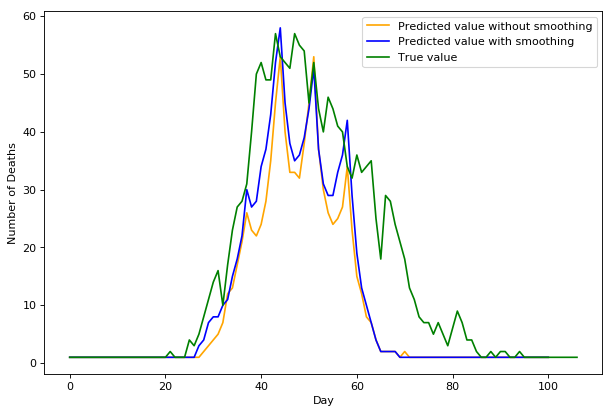

In [44]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot('111')
plt.plot(np.append(y[:tr],y_normal), 'orange', np.append(y[:tr],y_smoothed), 'blue', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value without smoothing','Predicted value with smoothing', 'True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

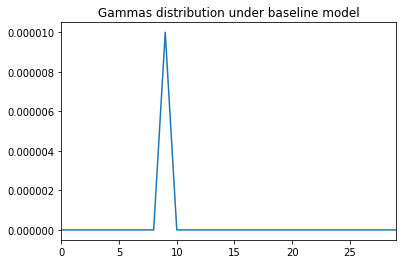

In [31]:
pd.DataFrame(gammas_normal[2]).plot(title='Gammas distribution under baseline model',legend=None)

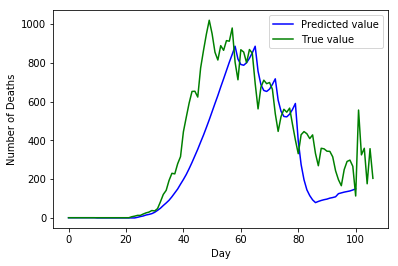

In [492]:
plt.plot(np.append(y[:tr],exponential_smoothing(y_preds, 0.65, 7)), 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

In [470]:
#print alongside the plot the value of number of infected
#infected = []
#indexes = []
#for gamma in gammas:
 #   indexes.append(np.argmax(gamma))

indexes1 = list(itertools.chain.from_iterable(itertools.repeat(x, 7) for x in indexes))
rs1 = list(itertools.chain.from_iterable(itertools.repeat(x, 7) for x in rs))
print(len(indexes1), len(rs1))
X_tocheck = X[tr:,:]
for i in range(len(y_preds)):
    infected.append(0.001*X[i,indexes1[i]])
    

98 98


In [543]:
plt.plot(np.append(y[:tr], y_preds), 'b', y, 'g', infected, 'grey')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value','Number of infected'])
#plt.title('Daily number of deaths in France due to the Covid-19')

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

In [472]:
np.mean(temp_mapes)

0.2870014921831089

### Without smoothing

In [473]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [493]:
N = X.shape[1]
loss=[]
for tr in tqdm(training_poss):

    splits = int(np.floor((X.shape[0] - tr)/7))

    # list of the mape for a given split, this list is reinitialized for every K
    temp_mapes = []
    y_vals = []
    indexes = []
    y_preds = []
    gammas = []
    range_r = [0.00001,0.0001,0.001,0.01, 0.1, 1]
    rs = []
    for i in range(splits):

        begin = 7*i
        end = tr + 7*i

        X_tr = X[begin:end,:]
        y_tr = y[begin:end]

        X_te = X[end:end+7,:]
        y_te = y[end:end+7]

        mape_per_r = []
        indexes_temp = []
        for r in range_r:

            index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
            P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
            gamma = cvxopt_solve_qp(P, q, G, h, A,b)
            y_pred = X_te@gamma
            y_pred[y_pred < 1 ] = 1
            y_pred = np.floor(y_pred)
            mape_per_r.append(mape(y_te, y_pred))

        r = range_r[np.argmin(mape_per_r)]
        rs.append(r)
        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
        indexes.append(index)
        #print('Best r for given split is', r)
        P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h, A,b)
        y_pred = X_te@gamma
        y_pred[y_pred < 1 ] = 1
        y_pred = np.floor(y_pred)
        temp_mapes.append(mape(y_te, y_pred))
        y_preds.append(y_pred)
    loss.append(np.mean(temp_mapes))
    
y_preds = [item for sublist in y_preds for item in sublist]












  0%|          | 0/7 [00:00<?, ?it/s]









 14%|█▍        | 1/7 [00:04<00:25,  4.22s/it]









 29%|██▊       | 2/7 [00:08<00:21,  4.21s/it]









 43%|████▎     | 3/7 [00:13<00:17,  4.46s/it]









 57%|█████▋    | 4/7 [00:20<00:15,  5.31s/it]









 71%|███████▏  | 5/7 [00:25<00:10,  5.11s/it]









 86%|████████▌ | 6/7 [00:29<00:04,  4.93s/it]









100%|██████████| 7/7 [00:33<00:00,  4.65s/it]

In [494]:
loss

[0.2706246404081284,
 0.3036439209840047,
 0.319083739219582,
 0.3243152228853741,
 0.32381104994662474,
 0.28673336906903757,
 0.2880309839560601]

In [495]:
training_poss

array([3, 4, 5, 6, 7, 8, 9])

In [496]:
tr = training_poss[np.argmin(loss)]

loss = []

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))

# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds = []

for i in range(splits):

    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]
        
    mape_per_r = []
    indexes_temp = []
    for r in range_r:

        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
        P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h, A,b)
        y_pred = X_te@gamma
        y_pred[y_pred < 1 ] = 1
        y_pred = np.floor(y_pred)
        mape_per_r.append(mape(y_te, y_pred))
        
    r = range_r[np.argmin(mape_per_r)]
    rs.append(r)
    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N, r)
    indexes.append(index)
    #print('Best r for given split is', r)
    P, q, G, h, A, b = generate_params(X_tr, y_tr, index, N, r, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h, A,b)
    y_pred = X_te@gamma
    y_pred[y_pred < 1 ] = 1
    y_pred = np.floor(y_pred)
    temp_mapes.append(mape(y_te, y_pred))
    y_preds.append(y_pred)

loss.append(np.mean(temp_mapes))


In [497]:
y_preds = [item for sublist in y_preds for item in sublist]


In [498]:
print('The minimum loss of ', np.min(loss), ' is obtained using ', training_poss[np.argmin(loss)], 'training days') 


The minimum loss of  0.2706246404081284  is obtained using  3 training days


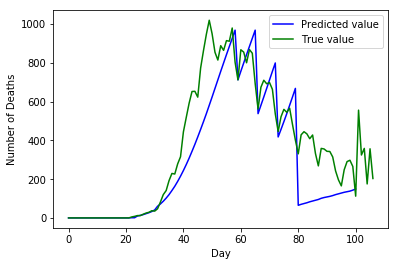

In [499]:
plt.plot(np.append(y[:tr],y_preds), 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')